# Data augmentation methods for pixel-wise satellite time series

Data augmentation is an effective preprocessing step to prevent deep neural networks from overfitting when labeled data is scarce. However, there has been no detailed investigation of data augmentation approaches suitable for satellite image time series (SITS) classification. In this demon, we present ten alternative augmentation techniques for pixel-wise satellite time series, including Noise Injection, Scaling, Mixup, Weighted DBA, Temporal Dropout, Window Slicing, Temporal shift, Time Warping, Interpolation Resampling, Amplitude Jittering, and Phase Jittering. Using the TimeSen2Crop dataset as an illustrative example, we detail the implementation process for each of these methods.

## load a sample time series 

In [1]:
'''
File 'timestep.json' records the number of days between the acquisition date and the start date (September 1, 2017) for 
each satellite image in the time series.
'''
import os
import numpy as np
import json
import pandas as pd
import random 
import dtw

time_file = './sample_data/timestep.json'    
file = open(time_file, 'r')
time_dict = json.load(file)
file.close()

class_num = 16  # total number of classes

In [2]:
def get_item(df, tile_num, class_label, time_dict):
    # only use cloud-free observations
    cloudfree_index = df[df["Flag"] == 0].index.values
    time = np.array(time_dict[tile_num], dtype=np.int64)[cloudfree_index]       # time steps, or sampling dates
    ts = df.iloc[cloudfree_index, 0:9].to_numpy() / 10000.0    # without normalization, only for illustration 
    label = np.zeros((class_num,), dtype=int)
    label[class_label] = 1
    return time, ts, label

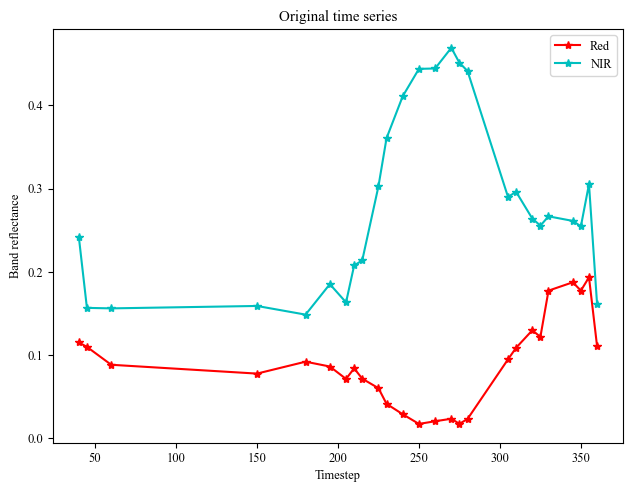

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 9
plt.rcParams['font.family'] = 'Times New Roman'

# path to a sample time series in the TimeSen2Crop dataset
data_file = './sample_data/33UUP/12/4.csv'
tile_num = '33UUP'
class_label = 12
df = pd.read_csv(data_file)
time_origin, ts_origin, label_origin = get_item(df, tile_num, class_label, time_dict) 

plt.figure()
plt.plot(time_origin, ts_origin[:, 2], 'r*-')
plt.plot(time_origin, ts_origin[:, 6], 'c*-')
plt.xlabel('Timestep')
plt.ylabel('Band reflectance')
plt.legend(['Red', 'NIR'])
plt.tight_layout()
plt.title('Original time series')
plt.show()

##  Augmentation 1: Noise injection

Noise Injection directly adds zero-mean Gaussian noise with a user-specified standard deviation to an input time series.

In [4]:
def InjectNoise(ts, time, sigma):
    """
    Inject noise into the input time series
    
    :param ts: original time series
    :param time: the number of days from the starting date for each observation in the time series
    :param sigma: standard deviation of the noise
    :return: noisy time series
    """
    assert(sigma > 0)
    noise = np.random.normal(loc=0, scale=sigma, size=ts.shape)
    ts_aug = ts + noise
    return ts_aug, time

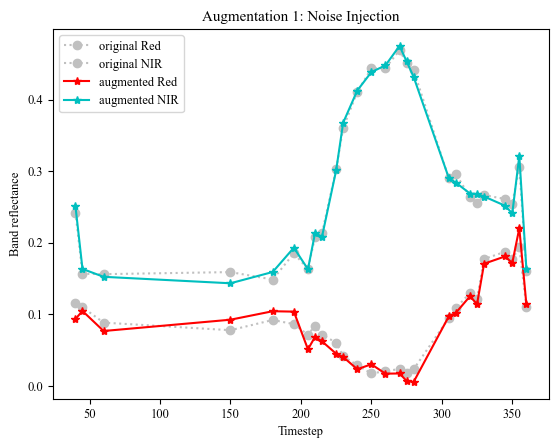

In [5]:
sigma = 0.01
ts_aug, time_aug = InjectNoise(ts_origin, time_origin, sigma)

plt.figure()
plt.plot(time_origin, ts_origin[:, 2], color='silver', marker='o', linestyle=':', label='original Red')
plt.plot(time_origin, ts_origin[:, 6], color='silver', marker='o', linestyle=':', label='original NIR')
plt.plot(time_aug, ts_aug[:, 2], 'r*-', label='augmented Red')
plt.plot(time_aug, ts_aug[:, 6], 'c*-', label='augmented NIR')
plt.xlabel('Timestep')
plt.ylabel('Band reflectance')
plt.legend()
plt.title('Augmentation 1: Noise Injection')
plt.show()

## Augmentation 2: Scaling

Scaling multiplies an input time series by a scaling factor randomly drawn from a Gaussian distribution with mean 1 and a user-specified standard deviation.

In [8]:
def Scale(ts, time, sigma):
    """
    Scale the magnitude of the input time series
    
    :param ts: original time series
    :param time: the number of days from the starting date for each observation in the time series
    :param sigma: standard deviation of the scaling factor
    :return: scaled time series
    """
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1, ts.shape[1]))  # shape=(1,3)
    noise = np.matmul(np.ones((ts.shape[0], 1)), scalingFactor)
    ts_aug = ts * noise
    return ts_aug, time

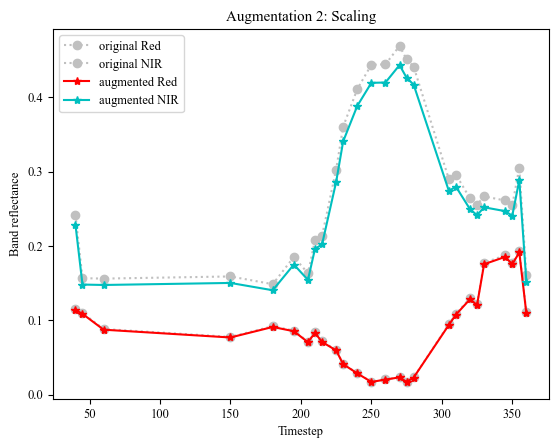

In [9]:
sigma = 0.1
ts_aug, time_aug = Scale(ts_origin, time_origin, sigma)

plt.figure()
plt.plot(time_origin, ts_origin[:, 2], color='silver', marker='o', linestyle=':', label='original Red')
plt.plot(time_origin, ts_origin[:, 6], color='silver', marker='o', linestyle=':', label='original NIR')
plt.plot(time_aug, ts_aug[:, 2], 'r*-', label='augmented Red')
plt.plot(time_aug, ts_aug[:, 6], 'c*-', label='augmented NIR')
plt.xlabel('Timestep')
plt.ylabel('Band reflectance')
plt.legend()
plt.title('Augmentation 2: Scaling')
plt.show()

## Augmentation 3: Mixup

Mixup linearly merges two samples as well as their class probability vectors at a certain ratio to synthesize a new sample.

In [12]:
from scipy import interpolate

def Mixup(ts_origin, time_origin, label_origin, ts_new, time_new, label_new, alpha):
    """
    Mix up two time series and their class probability vectors
    
    :param ts_origin: original time series
    :param time_origin: the number of days from the starting date for each observation in the original time series
    :param label_origin: label of ts_origin
    :param ts_new: another time series to mix with the original one
    :param time_new: the number of days from the starting date for each observation in ts_new
    :param label_new: label of ts_new
    :param alpha: Uniform sampling range of the mixing ratio
    :return: mixed time series and mixed label
    """
    T, C = ts_origin.shape
    ts_interpol = np.zeros(shape=ts_origin.shape)
    for channel in range(C):
        F = interpolate.interp1d(time_new, ts_new[:, channel], kind='linear', fill_value='extrapolate')
        ts_interpol[:, channel] = F(time_origin)
        
    ratio = np.random.uniform(0, alpha)     # mixing ratio
    ts_mix = ts_origin * (1 - ratio) + ts_interpol * ratio
    label_mix = label_origin * (1 - ratio) + label_new * ratio
    return ts_mix, time_origin, label_mix

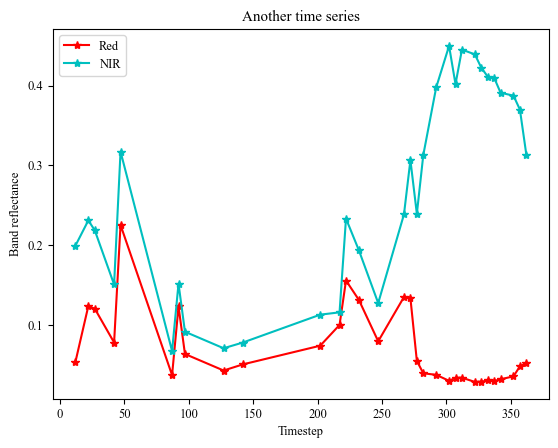

In [13]:
# load another satellite time series
data_file = './sample_data/33TWM/2/1.csv'
tile_num = '33TWM'
class_label = 2
df = pd.read_csv(data_file)
time2, ts2, _ = get_item(df, tile_num, class_label, time_dict) 

plt.figure()
plt.plot(time2, ts2[:, 2], 'r*-')
plt.plot(time2, ts2[:, 6], 'c*-')
plt.xlabel('Timestep')
plt.ylabel('Band reflectance')
plt.legend(['Red', 'NIR'])
plt.title('Another time series')
plt.show()

mixed one-hot labels: [0.         0.         0.70860279 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.29139721 0.         0.         0.        ]


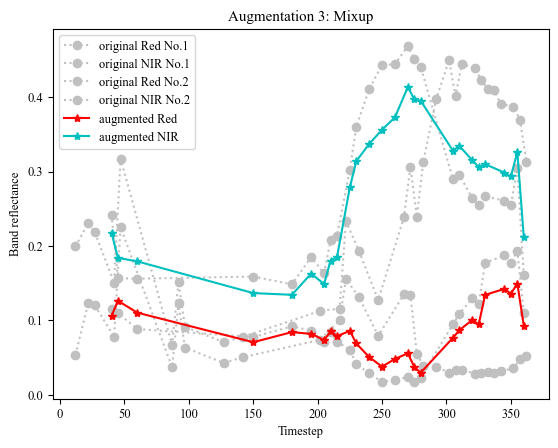

In [14]:
# generate one-hot label vector
label1 = np.zeros((class_num,), dtype=int)
label1[2] = 1
label2 = np.zeros((class_num,), dtype=int)
label2[12] = 1

alpha = 0.5
ts_mix, time_mix, label_mix = Mixup(ts_origin, time_origin, label1, ts2, time2, label2, alpha)

print('mixed one-hot labels:', label_mix)
plt.figure()
plt.plot(time_origin, ts_origin[:, 2], color='silver', marker='o', linestyle=':', label='original Red No.1')
plt.plot(time_origin, ts_origin[:, 6], color='silver', marker='o', linestyle=':', label='original NIR No.1')
plt.plot(time2, ts2[:, 2], color='silver', marker='o', linestyle=':', label='original Red No.2')
plt.plot(time2, ts2[:, 6], color='silver', marker='o', linestyle=':', label='original NIR No.2')
plt.plot(time_mix, ts_mix[:, 2], 'r*-', label='augmented Red')
plt.plot(time_mix, ts_mix[:, 6], 'c*-', label='augmented NIR')
plt.xlabel('Timestep')
plt.ylabel('Band reflectance')
plt.legend()
plt.title('Augmentation 3: Mixup')
plt.show()

## Weighted DBA 

Weighted DBA calculates a weighted average of two time series that belong to the same category using the DTW distance metric. First, an initial time series, denoted as T1, is chosen from the training set with an assigned weight of 1, serving as the medoid for DBA (Dynamic Time Warping Barycenter Averaging). Subsequently, 5 candidate time series, consistent with the category of T1, are extracted from the training set. Among these candidates, only the one that is nearest to  T1, denoted as T2, is retained and assigned a weight of 0.5. Finally, the weighted DBA algorithm is employed to compute the average time series based on  T1 and T2, which is then normalized by the sum of their weights.

In [15]:
def WeightedDBA(ts, time, candidates, cost_mat, path_mat, delta_mat, tmp_delta_mat):
    """
    Compute the Weighted DBA of a given time series and its candidates.
    
    :param ts: The initial time series.
    :param candidates: A list of candidate time series.
    :param cost_mat, path_mat, delta_mat, tmp_delta_mat: Matrices for DTW computation.
    :return: averaged time series and its nearest neighbor
    """
    # Compute DTW distances for all candidates
    neighbor_dist = [dtw.DTW(ts.T, ts_new.T, cost_mat, delta_mat, tmp_delta_mat) for ts_new, _ in candidates]
    
    # Find the nearest neighbor
    nearest_idx = np.argmin(neighbor_dist)
    ts_neighbor, time_neighbor = candidates[nearest_idx]
    series = [ts.T, ts_neighbor.T]

    # Assign weights
    weights = np.array([1.0, 0.5])

    # Update center using DBA
    for _ in range(5):
        ts = dtw.DBA_update(ts.T, series, weights, cost_mat, path_mat, delta_mat, tmp_delta_mat).T
    
    return ts, time, ts_neighbor, time_neighbor 

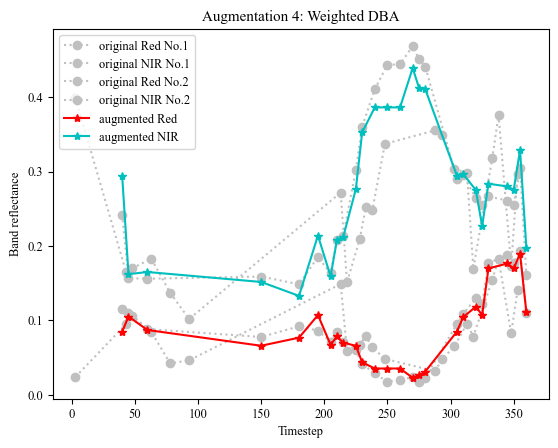

In [16]:
# load a set of satellite time series of the same category
file_path = './sample_data/32TPT/12'
tile_num = '32TPT'
class_label = 12
files = os.listdir(file_path)
ts_set = []
for file in files:
    data_file = os.path.join(file_path, file)
    df = pd.read_csv(data_file)
    timej, tsj, _ = get_item(df, tile_num, class_label, time_dict) 
    ts_set.append((tsj, timej))

# Initialize matrices for DTW computation
length = 40
cost_mat = np.zeros((length, length))
delta_mat = np.zeros((length, length))
tmp_delta_mat = np.zeros((length, length))
path_mat = np.zeros((length, length), dtype=np.int8)

# Select random candidates
k = min(5, len(ts_set))
candidates = random.sample(ts_set, k)

# Compute Weighted DBA
ts_aug, time_aug, neighbor_ts, neighbor_time = WeightedDBA(ts_origin, time_origin, candidates, 
                                                           cost_mat, path_mat, delta_mat, tmp_delta_mat)

plt.figure()
plt.plot(time_origin, ts_origin[:, 2], color='silver', marker='o', linestyle=':', label='original Red No.1')
plt.plot(time_origin, ts_origin[:, 6], color='silver', marker='o', linestyle=':', label='original NIR No.1')
plt.plot(neighbor_time, neighbor_ts[:, 2], color='silver', marker='o', linestyle=':', label='original Red No.2')
plt.plot(neighbor_time, neighbor_ts[:, 6], color='silver', marker='o', linestyle=':', label='original NIR No.2')
plt.plot(time_aug, ts_aug[:, 2], 'r*-', label='augmented Red')
plt.plot(time_aug, ts_aug[:, 6], 'c*-', label='augmented NIR')
plt.xlabel('Timestep')
plt.ylabel('Band reflectance')
plt.legend()
plt.title('Augmentation 4: Weighted DBA')
plt.show()

## Augmentation 5: Temporal Dropout 

Temporal Dropout randomly discards some observations in a time series.

In [17]:
def TemporalDropout(ts, time, drop_rate):
    """
    Temporally drop some observations from the input time series
    
    :param ts: original time series
    :param time: the number of days from the starting date for each observation in the time series
    :param drop_rate: the proportion of observations to drop
    :return: time series after droping
    """
    T = time.shape[0]
    retain_length = max(int(T * (1 - drop_rate)), 3)  # at least retain 3 observations
    idx = np.random.choice(T, retain_length, replace=False)
    idx.sort()          # inplace
    ts_aug = ts[idx]
    time_aug = time[idx]
    return ts_aug, time_aug

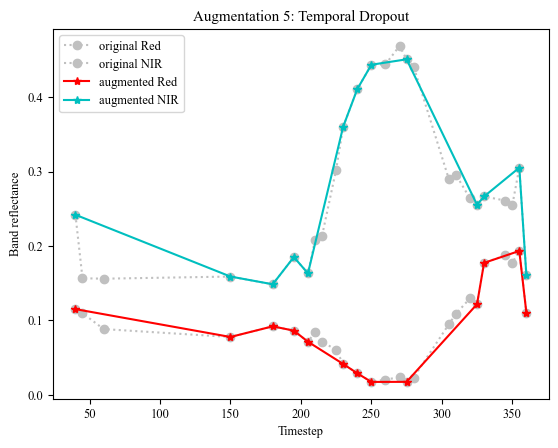

In [18]:
drop_rate = 0.5
ts_aug, time_aug = TemporalDropout(ts_origin, time_origin, drop_rate)

plt.figure()
plt.plot(time_origin, ts_origin[:, 2], color='silver', marker='o', linestyle=':', label='original Red')
plt.plot(time_origin, ts_origin[:, 6], color='silver', marker='o', linestyle=':', label='original NIR')
plt.plot(time_aug, ts_aug[:, 2], 'r*-', label='augmented Red')
plt.plot(time_aug, ts_aug[:, 6], 'c*-', label='augmented NIR')
plt.xlabel('Timestep')
plt.ylabel('Band reflectance')
plt.legend()
plt.title('Augmentation 5: Temporal Dropout')
plt.show()

## Augmentation 6: Window Slicing

Window Slicing randomly crops a subsequence from the original time series as a new sample.

In [19]:
def WindowSlice(ts, time, clip_ratio):
    """
    Slice the input time series within a window
    
    :param ts: original time series
    :param time: the number of days from the starting date for each observation in the time series
    :param clip_ratio: the proportion of observations to retain
    :return: time series after slicing
    """
    T = time.shape[0]
    retain_length = min(max(int(T * clip_ratio), 3), T)  # at least retain 3 observations
    start = np.random.randint(0, T-retain_length)
    end = start+retain_length
    ts_aug = ts[start: end, :]
    time_aug = time[start: end]
    return ts_aug, time_aug

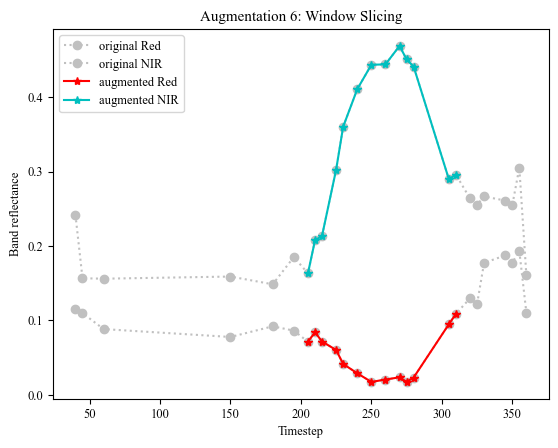

In [20]:
clip_ratio = 0.5 
ts_aug, time_aug = WindowSlice(ts_origin, time_origin, clip_ratio)

plt.figure()
plt.plot(time_origin, ts_origin[:, 2], color='silver', marker='o', linestyle=':', label='original Red')
plt.plot(time_origin, ts_origin[:, 6], color='silver', marker='o', linestyle=':', label='original NIR')
plt.plot(time_aug, ts_aug[:, 2], 'r*-', label='augmented Red')
plt.plot(time_aug, ts_aug[:, 6], 'c*-', label='augmented NIR')
plt.xlabel('Timestep')
plt.ylabel('Band reflectance')
plt.legend()
plt.title('Augmentation 6: Window Slicing')
plt.show()

## Augmentation 7: Temporal Shift

Temporal Shift randomly shifts all the acquisition dates of a satellite time series forward or backward by several days.

In [21]:
def TemporalShift(ts, time, srange):
    """
    Temporally shift the input time series
    
    :param ts: original time series
    :param time: the number of days from the starting date for each observation in the time series
    :param srange: the maximum allowable shift days
    :return: time series after shifting
    """
    shift = max(round(np.random.uniform(-srange, srange)), -time[0])
    time_aug = time + shift
    return ts, time_aug

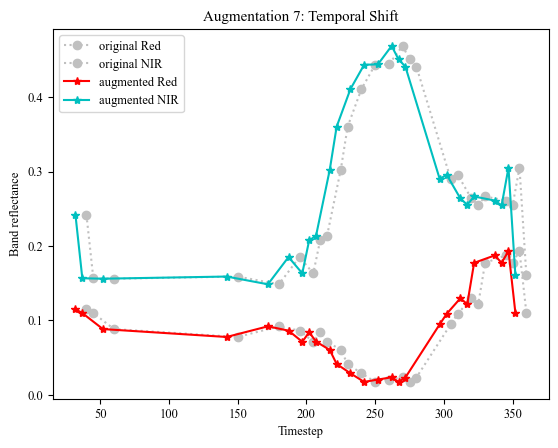

In [22]:
srange = 20
ts_aug, time_aug = TemporalShift(ts_origin, time_origin, srange)

plt.figure()
plt.plot(time_origin, ts_origin[:, 2], color='silver', marker='o', linestyle=':', label='original Red')
plt.plot(time_origin, ts_origin[:, 6], color='silver', marker='o', linestyle=':', label='original NIR')
plt.plot(time_aug, ts_aug[:, 2], 'r*-', label='augmented Red')
plt.plot(time_aug, ts_aug[:, 6], 'c*-', label='augmented NIR')
plt.xlabel('Timestep')
plt.ylabel('Band reflectance')
plt.legend()
plt.title('Augmentation 7: Temporal Shift')
plt.show()

##  Augmentation 8: Time Warping

Time warping first interpolates an irregularly sampled satellite time series into a regular one, and then alters the timeline with a random warping curve. The warping curve is defined by a cubic spline fitted with five knots. The hights of these knots are randomly drawn from a Gaussion distribution with mean 1 and a user-specified standard deviation. The implementation is mostly based on Terry Um's work (https://github.com/terryum/Data-Augmentation-For-Wearable-Sensor-Data).

In [23]:
from scipy.interpolate import CubicSpline  

def GenerateRandomCurve(X, sigma, knot, period):
    """
    Generate a random curve
    
    :param X: a time series of shape (T, C)
    :param sigma: standard deviation of the random perturbations
    :param knot: number of knots
    :param period: usually one year, or 366 days
    :return: a warping curve with the same size as X
    """
    x_range = np.arange(period+1)
    xx = np.linspace(0, period, knot + 2)  
    yy = np.random.normal(loc=1.0, scale=sigma, size=(knot + 2, )) 
    spline = CubicSpline(xx, yy)(x_range)
    return spline 

In [24]:
def TimeWarp(ts, time, sigma, knot=5):
    """
    Temporally warp the input time series after interpolation.
    
    :param ts: original time series
    :param time: the number of days from the starting date for each observation in the time series
    :param sigma: standard deviation of the random curve
    :param knot: number of knots for the cubic spline
    :return: time series after warping
    """
    # generate a random warping curve
    period = 366
    tt = GenerateRandomCurve(ts, sigma, knot, period)
    tt_cum = np.cumsum(tt, axis=0)  # Cumulative sum to get the warped time points 
    t_scale = period / tt_cum[-1]   # Scaling factor to ensure the last point matches the period
    tt_cum *= t_scale

    T, C = ts.shape
    X = np.arange(period+1) 
    ts_aug = np.zeros(ts.shape)
    for c in range(C):
        # Interpolate the original time series to get values at all time points
        F = interpolate.interp1d(time, ts[:, c], kind='linear', fill_value='extrapolate')
        Y = F(X)   
        ts_aug[:, c] = np.interp(time, xp=tt_cum, fp=Y)  # Warp the time series using the random curve
    return ts_aug, time

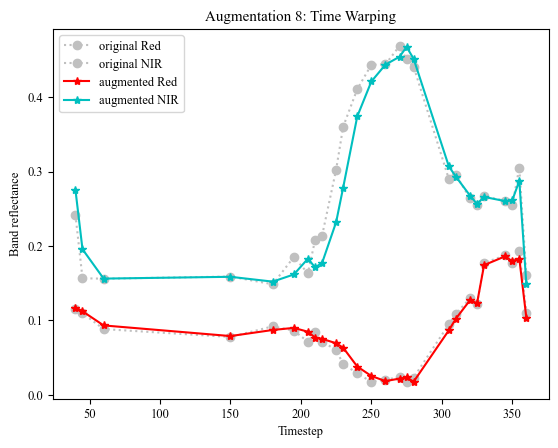

In [25]:
sigma = 0.1
ts_aug, time_aug = TimeWarp(ts_origin, time_origin, sigma)

plt.figure()
plt.plot(time_origin, ts_origin[:, 2], color='silver', marker='o', linestyle=':', label='original Red')
plt.plot(time_origin, ts_origin[:, 6], color='silver', marker='o', linestyle=':', label='original NIR')
plt.plot(time_aug, ts_aug[:, 2], 'r*-', label='augmented Red')
plt.plot(time_aug, ts_aug[:, 6], 'c*-', label='augmented NIR')
plt.xlabel('Timestep')
plt.ylabel('Band reflectance')
plt.legend()
plt.title('Augmentation 8: Time Warping')
plt.show()

##  Augmentation 9: Interpolation Resampling

Interpolation Resampling changes the temporal positions of an irregularly-sampled satellite time series. It starts by interpolating a satellite time series into equally spaced sampling times and then randomly discards some time points to construct a new time series that is temporally redistributed.

In [26]:
def Resample(ts, time, resample_ratio):
    """
    Temporally resample the input time series after interpolation
    
    :param ts: original time series
    :param time: the number of days from the starting date for each observation in the time series
    :param resample_ratio: the proportion of observations to retain after resampling
    :return: time series after resampling
    """
    step = 5
    offset = 0
    T, C = ts.shape
    X = np.arange(time[0]+offset, time[-1]+1, step)
    retain_length = min(max(int(T * resample_ratio), 3), X.shape[0])  # at least retain 3 observations
    idx = np.random.choice(X.shape[0], retain_length, replace=False)
    idx.sort()
    time_aug = X[idx]

    ts_aug = np.zeros(shape=[retain_length, C], dtype=np.float32)
    for c in range(C):
        F = interpolate.interp1d(time, ts[:, c], kind='linear', fill_value='extrapolate')
        Y = F(X)
        ts_aug[:, c] = Y[idx]
    return ts_aug, time_aug

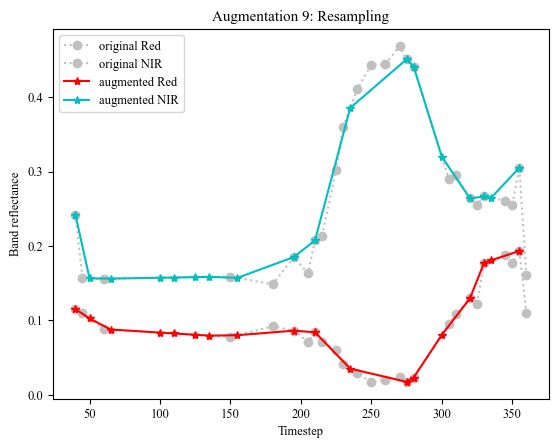

In [27]:
# sparse resampling (resample_ratio <1)
resample_ratio = 0.7 
ts_aug, time_aug = Resample(ts_origin, time_origin, resample_ratio)

plt.figure()
plt.plot(time_origin, ts_origin[:, 2], color='silver', marker='o', linestyle=':', label='original Red')
plt.plot(time_origin, ts_origin[:, 6], color='silver', marker='o', linestyle=':', label='original NIR')
plt.plot(time_aug, ts_aug[:, 2], 'r*-', label='augmented Red')
plt.plot(time_aug, ts_aug[:, 6], 'c*-', label='augmented NIR')
plt.xlabel('Timestep')
plt.ylabel('Band reflectance')
plt.legend()
plt.title('Augmentation 9: Resampling')
plt.show()


## Augmentation 10: Amplitude Jittering

Amplitude jittering perturbs the amplitude spectrum of a time series in the frequency domain by replacing a segment of the amplitude spectrum with random Gaussion noise. A change ratio controls the ratio of the lengths between the segment and the whole time series.

In [28]:
from scipy.fftpack import fft, ifft

def AmplitudeJitter(ts, time, change_ratio):
    """
    Jitter the amplitude spectrum of the input time series
    
    :param ts: original time series
    :param time: the number of days from the starting date for each observation in the time series
    :param change_ratio: the ratio of changed length in amplitude
    :return: time series after amplitude jittering
    """
    period = 366  # a year
    T, C = ts.shape
    change_length = int((time[-1] - time[0]) * change_ratio) 
    X = np.arange(0, period+1, 1) 
    choice = np.random.randint(10, time[-1]-change_length-10)
    change_range = X[choice:choice+change_length]  

    ts_aug = np.zeros(shape=ts.shape, dtype=np.float32)
    for c in range(C):
        F = interpolate.interp1d(time, ts[:, c], kind='linear', fill_value='extrapolate') # interpolate to daily time series
        Y = F(X)        
        
        # convert to frequency domain
        Y_fft = fft(Y)             
        amplit = abs(Y_fft)        # amplitude spectrum
        phase = np.angle(Y_fft)    # phase spectrum
        m = np.mean(amplit[change_range])     
        std = np.std(amplit[change_range])    
        noise = np.random.normal(loc=m, scale=std, size=(change_length,))
        amplit_noisy = np.copy(amplit)
        amplit_noisy[change_range] = noise  # replace the original subsequence with noise
        
        # convert to spatial domain
        Y_aug = ifft(amplit_noisy * np.cos(phase) + amplit_noisy * np.sin(phase) * 1j)  
        ts_aug[:, c] = Y_aug[time].real
    
    return ts_aug, time

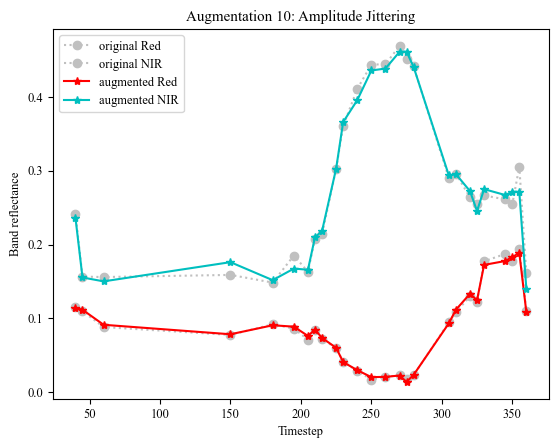

In [34]:
change_ratio = 0.5
ts_aug, time_aug = AmplitudeJitter(ts_origin, time_origin, change_ratio)

plt.figure()
plt.plot(time_origin, ts_origin[:, 2], color='silver', marker='o', linestyle=':', label='original Red')
plt.plot(time_origin, ts_origin[:, 6], color='silver', marker='o', linestyle=':', label='original NIR')
plt.plot(time_aug, ts_aug[:, 2], 'r*-', label='augmented Red')
plt.plot(time_aug, ts_aug[:, 6], 'c*-', label='augmented NIR')
plt.xlabel('Timestep')
plt.ylabel('Band reflectance')
plt.legend()
plt.title('Augmentation 10: Amplitude Jittering')
plt.show()

## Augmentation 11: Phase Jittering

Phase jittering perturbs the phase spectrum of a time series in the frequency domain by adding zero-mean Gaussian noise. The noise intensity is controlled by a hyperparameter sigma, which is defined as the ratio of standard deviations between the noise and the original time series.

In [37]:
def PhaseJitter(ts, time, sigma):
    """
    Jitter the phase spectrum of the input time series
    
    :param ts: original time series
    :param time: the number of days from the starting date for each observation in the time series
    :param sigma: standard deviation of the random noise
    :return: time series after phase jittering
    """
    period = 366
    T, C = ts.shape
    X = np.arange(0, period+1, 1)
    
    ts_aug = np.zeros(shape=ts.shape, dtype=np.float32)
    for c in range(C):
        F = interpolate.interp1d(time, ts[:, c], kind='linear', fill_value='extrapolate') # interpolate to daily time series
        Y = F(X)        
        
        # convert to frequency domain
        Y_fft = fft(Y)             
        amplit = abs(Y_fft)        # amplitude spectrum
        phase = np.angle(Y_fft)    # phase spectrum
        std = np.std(phase)
        noise = np.random.normal(loc=0.0, scale=sigma*std, size=(367,))
        phase_noisy = phase + noise   
        
        # convert to spatial domain
        Y_aug = ifft(amplit * np.cos(phase_noisy) + amplit * np.sin(phase_noisy) * 1j)
        ts_aug[:, c] = Y_aug[time].real

    return ts_aug, time

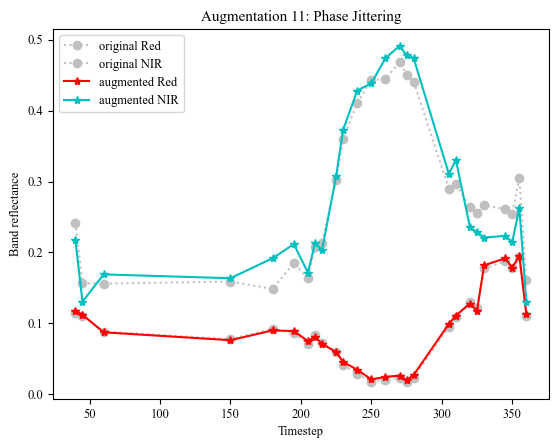

In [38]:
sigma = 0.2
ts_aug, time_aug = PhaseJitter(ts_origin, time_origin, sigma)

plt.figure()
plt.plot(time_origin, ts_origin[:, 2], color='silver', marker='o', linestyle=':', label='original Red')
plt.plot(time_origin, ts_origin[:, 6], color='silver', marker='o', linestyle=':', label='original NIR')
plt.plot(time_aug, ts_aug[:, 2], 'r*-', label='augmented Red')
plt.plot(time_aug, ts_aug[:, 6], 'c*-', label='augmented NIR')
plt.xlabel('Timestep')
plt.ylabel('Band reflectance')
plt.legend()
plt.title('Augmentation 11: Phase Jittering')
plt.show()